# Importing dependencies

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
import time
import seaborn as sns
import networkx as nx
%matplotlib inline
# #!pip install ipympl
# %matplotlib widget
import sys
import os
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath("../external"))
sys.path.append(os.path.abspath("../external/causal_comp"))
sys.path.append(os.path.abspath("../external/tigramite"))

# seed = 42
# np.random.seed(seed)

# For Liang-Kleeman Information Flow
from causal_comp.function_liang_nvar import compute_sig
from causal_comp.function_liang_nvar import compute_liang_nvar
import visualize_results
from visualize_results import visualize_liang_results
from visualize_results import plot_heatmap
# For PCMCI
from tigramite.data_processing import DataFrame
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.pcmci import PCMCI

# 2D model

## LKIFR

In [2]:
# Time series
load_series = True # True: load time series; False: compute and save new time series
load_var_results = False

filename = '../data/2D_series.npy'
var_filename = '../results/npy/2D_liang.npy'
if load_series == True: # load precomputed time series
    t, X1, X2 = np.load(filename, allow_pickle=True)
if load_var_results:
    T, tau, R, error_T, error_tau, error_R, sig_T, sig_tau, sig_R = np.load(var_filename, allow_pickle=True)

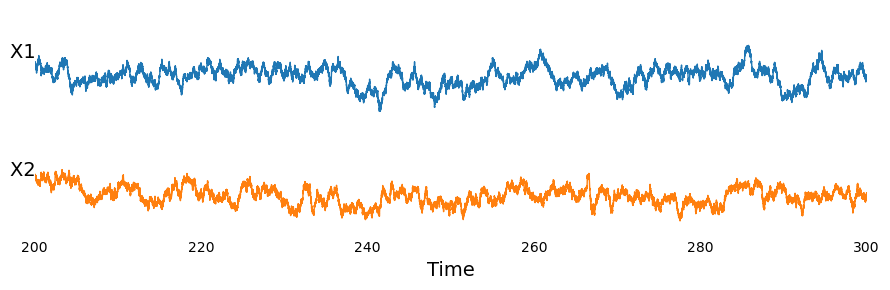

In [17]:
# Plotting the 2D system
series= [X1, X2]
labels = ['X1  ', 'X2  ']
colors = ['tab:blue', 'tab:orange']

fig, axes = plt.subplots(2, 1, figsize=(9, 3), sharex=True)

for i in range(2):
    axes[i].plot(t, series[i], color=colors[i], linewidth=1, label=labels[i])
    axes[i].set_ylabel(labels[i], rotation=0, size=14)
    axes[i].set_xlim(200, 300)
    axes[i].set_ylim(-0.3,0.5)

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].tick_params(left=False, labelleft=False, bottom=False)  # hides y-ticks and labels

axes[-1].set_xlabel('Time', size=14)

plt.tight_layout()
plt.show()


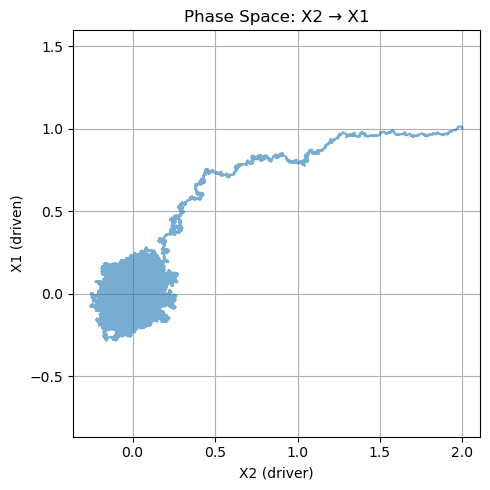

In [18]:
plt.figure(figsize=(5, 5))
plt.plot(X2, X1, alpha=0.6)
plt.xlabel('X2 (driver)')
plt.ylabel('X1 (driven)')
plt.title('Phase Space: X2 → X1')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [3]:
# Time Parameters and Simulation Settings
dt = 0.001
tmax = 1000 # takes around 9 mins
nt = int(tmax / dt)
t = np.linspace(0, tmax, nt)
start_computation = int(10 / dt)  # discard transients
n_iter = 200 # bootstrap samples for Liang
nvar = 2

In [6]:
if load_series==False:
    # Simulate 2D Time Series
    a11, a12 = -1, 0.5
    a21, a22 = 0, -1
    sigma1, sigma2 = 0.1, 0.1
    dW1 = np.sqrt(dt) * np.random.normal(0, 1, nt)
    dW2 = np.sqrt(dt) * np.random.normal(0, 1, nt)
    X1, X2 = np.zeros(nt), np.zeros(nt)
    X1[0], X2[0] = 1.0, 2.0
    
    for i in range(nt - 1):
        X1[i + 1] = X1[i] + (a11 * X1[i] + a12 * X2[i]) * dt + sigma1 * dW1[i]
        X2[i + 1] = X2[i] + (a22 * X2[i] + a21 * X1[i]) * dt + sigma2 * dW2[i]
    
    # Apply Liang-Kleeman Info Flow on Post-Transient Segment
    print("Computing the Information Flow Rate...")
    start_L2 = time.time()
    xx = np.array([X1[start_computation:], X2[start_computation:]])
    T, tau, R, error_T, error_tau, error_R = compute_liang_nvar(xx, dt, n_iter)
    print(f"LKIFR computation time: {time.time() - start_L2:.2f} seconds")

In [7]:
# # Significance Check (takes several minutes)
# alpha_level = 0.05   # controling false positives
# conf = norm.ppf(1 - alpha_level / 2)
# sig_T = np.zeros((nvar, nvar))
# sig_tau = np.zeros((nvar, nvar))
# sig_R = np.zeros((nvar, nvar))

# for j in range(nvar):
#     for k in range(nvar):
#         sig_T[j, k] = compute_sig(T[j, k], error_T[j, k], conf)
#         sig_tau[j, k] = compute_sig(tau[j, k], error_tau[j, k], conf)
#         sig_R[j, k] = compute_sig(R[j, k], error_R[j, k], conf)

In [8]:
# Printing LKIF results for 2D 
print("\nLiang-Kleeman Info Transfer (T):")
print(T)
print("\nNormalized Info Transfer (% tau):")
print(tau)
print("\nPearson Correlation (R):")
print(R)

print("\nSignificance of T (1=significant):")
print(sig_T)
print("\nSignificance of tau:")
print(sig_tau)
print("\nSignificance of R:")
print(sig_R)


Liang-Kleeman Info Transfer (T):
[[-0.97944602  0.00578939]
 [ 0.10135035 -1.0512221 ]]

Normalized Info Transfer (% tau):
[[-49.96531961   0.27532049]
 [  5.17027232 -49.9919793 ]]

Pearson Correlation (R):
[[1.         0.22942272]
 [0.22942272 1.        ]]

Significance of T (1=significant):
[[1. 0.]
 [1. 1.]]

Significance of tau:
[[1. 0.]
 [1. 1.]]

Significance of R:
[[1. 1.]
 [1. 1.]]


In [9]:
if load_series==False:
    # Save time series and results
    np.save('../data/2D_series_new.npy', [t, X1, X2])
    np.save('../results/npy/2D_liang_new.npy', [T, tau, R, error_T, error_tau, error_R, sig_T, sig_tau, sig_R])

#### draft computations

In [4]:
from function_liang import compute_liang
start_L2 = time.time()
xx = np.array([X1[start_computation:], X2[start_computation:]])
T, tau, R, error_T, error_tau, error_R, sig_T, sig_tau = compute_liang(
    xx,
    dt=0.001,
    n_iter=200,            # number of permutations
    method='permutation',
    return_sig=True,
    alpha=5                 # 5% significance
)
print(f"LKIFR with permutation test computation time: {time.time() - start_L2:.2f} seconds")


LKIFR with permutation test computation time: 61.40 seconds


In [5]:
T

array([[-9.79445029e-04,  5.78938249e-06],
       [ 1.01350248e-04, -1.05122104e-03]])

In [12]:
T # dt=0.001

array([[-0.97944503,  0.00578938],
       [ 0.10135025, -1.05122104]])

In [13]:
tau

array([[-49.96529696,   0.27532035],
       [  5.17026998, -49.99195419]])

In [15]:
sig_tau #2nd trial again wrong

array([[0, 1],
       [1, 0]])

#### aligned with matlab code

In [4]:
dt = 0.001
start_computation = int(10 / dt)  # discard transients
from function_liang import compute_liang
start_L2 = time.time()
xx = np.array([X1[start_computation:], X2[start_computation:]])
T, tau, R, error_T, error_tau, error_R, sig_T, sig_tau = compute_liang(
    xx,
    dt=0.001,
    n_iter=200,            # number of permutations
    method='permutation',
    return_sig=True,
    alpha=5                 # 5% significance
)
print(f"LKIFR with permutation test computation time: {time.time() - start_L2:.2f} seconds")
print("T\n", T)
print("tau\n", tau)
print("sig_T\n", sig_T)
print("sig_tau\n", sig_tau)

LKIFR with permutation test computation time: 59.02 seconds
T
 [[-0.97944503  0.00578938]
 [ 0.10135025 -1.05122104]]
tau
 [[-49.96529696   0.27532035]
 [  5.17026998 -49.99195419]]
sig_T
 [[0 0]
 [1 0]]
sig_tau
 [[0 0]
 [1 0]]


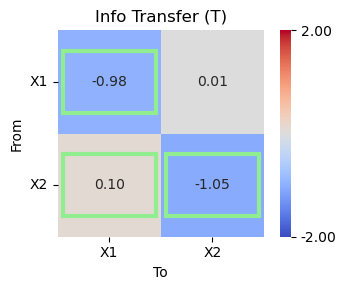

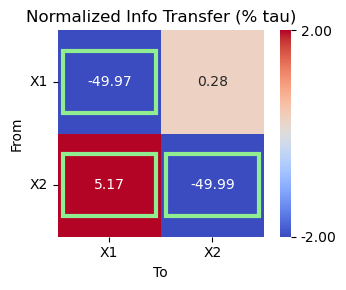

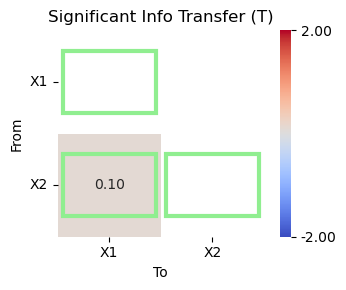

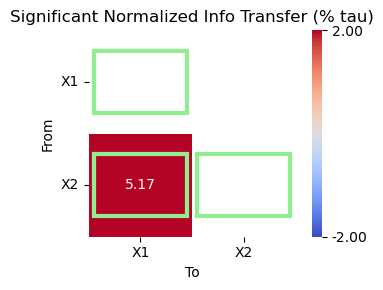

In [6]:
true_links_2d = [(0, 0), (1, 1), (1,0)]  # format: (from, to)
plot_heatmap(T, title='Info Transfer (T)', vmin=-2., vmax=2., true_links=true_links_2d, figsize=(4,3))
plot_heatmap(tau, title='Normalized Info Transfer (% tau)', vmin=-2, vmax=2, true_links=true_links_2d, figsize=(4,3))

# Plot significant only
plot_heatmap(T * sig_T, title='Significant Info Transfer (T)', vmin=-2, vmax=2, annot_mask=sig_T, true_links=true_links_2d, figsize=(4,3))
plot_heatmap(tau * sig_tau, title='Significant Normalized Info Transfer (% tau)', vmin=-2, vmax=2, annot_mask=sig_tau, true_links=true_links_2d, figsize=(4,3))

## PCMCI

Tigramite takes input data as 2D Numpy array of shape (T:num of timesteps, N:num of variables)
Our simulated series X1, X2 are shaped (nt,) that is, each is a separate 1D timeseries. So, 
we will make the array (2, T) and then we\ll transpose it to be ready for Tigramite's DataFrame class.

In [8]:
data_raw = np.array([X1[start_computation:], X2[start_computation:]]).T  # shape: (T, 2)
dataframe = DataFrame(data_raw, var_names=["X1", "X2"])

# Setting up ParCorr test and PCMCI object with TIGRAMITE
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr)
alpha_level = 0.05
tau_max = 3

# Running PCMCI (takes several minutes)
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=alpha_level)

# FDR-corrected p-values
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')

# Retrieving inferred parents from graph (but we'll use the FDR-corrected values)
parents_dict = pcmci.return_parents_dict(graph=results['graph'], val_matrix=results['val_matrix'])

# Printing results ##########
print(f'Note: Alpha level {alpha_level} means accepting a {alpha_level*100:.1f}% chance of falsely detecting a link that is not true.')
pcmci.print_significant_links(p_matrix = q_matrix, val_matrix = results['val_matrix'], alpha_level = alpha_level)
graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=alpha_level, tau_min=0, tau_max=tau_max, link_assumptions=None)
results['graph'] = graph

# Retrieving inferred parents from above (fdr corrected) graph
parents_dict = pcmci.return_parents_dict(graph=results['graph'], val_matrix=results['val_matrix'])

# Show beta (path coefficients) matrix at lag 1
print("\nPCMCI Path Coefficients (val_matrix) at lag=1:")
print(' ', results['val_matrix'][:, :, 1])

print("\nInferred parents per variable (from graph):")
for var, parents in parents_dict.items():
    varname = dataframe.var_names[var]
    formatted = ', '.join(f"{dataframe.var_names[pv]}(t{lag})" for pv, lag in parents)
    print(f"  {varname}(t) ← {formatted}")



Note: Alpha level 0.05 means accepting a 5.0% chance of falsely detecting a link that is not true.

## Significant links at alpha = 0.05:

    Variable X1 has 1 link(s):
        (X1 -1): pval = 0.00000 | val =  0.707

    Variable X2 has 1 link(s):
        (X2 -1): pval = 0.00000 | val =  0.706

PCMCI Path Coefficients (val_matrix) at lag=1:
  [[0.70656187 0.00194443]
 [0.00071363 0.7062371 ]]

Inferred parents per variable (from graph):
  X1(t) ← X1(t-1)
  X2(t) ← X2(t-1)


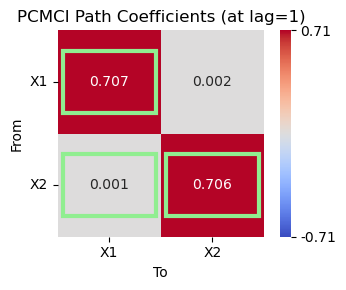

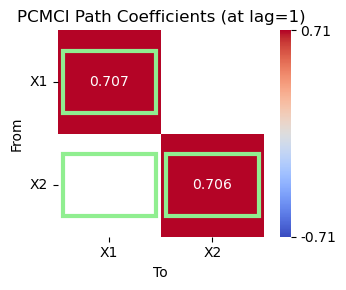

In [12]:
val1 = results['val_matrix'][:, :, 1]      # shape (2,2), coeff from j(t-1) → i(t)
p1   = q_matrix[:, :, 1]                  # FDR-corrected p-values at lag=1
alpha_level = 0.05
sig1 = (p1 < alpha_level)                 # True where link is significant
lim = np.max(np.abs(val1))
plot_heatmap(val1,title='PCMCI Path Coefficients (at lag=1)',vmin=-lim, vmax= lim, fmt=".3f",true_links=true_links_2d, figsize=(4,3))
plot_heatmap(val1,title='PCMCI Path Coefficients (at lag=1)',vmin=-lim, vmax= lim, fmt=".3f", annot_mask=sig1, true_links=true_links_2d, figsize=(4,3))


PCMCI misses the causal link from X2 to X1. The observation is that as the timestep decreases, PCMCI struggles to recover the correct links. Analysis with bigger timestep follows:

In [18]:
dt = 0.1 # the only change: instead of dt = 0.001
tmax = 1000
nt = int(tmax / dt)
t = np.linspace(0, tmax, nt)
start_computation = int(10 / dt)  # discard transients
n_iter = 200 # bootstrap samples for Liang
nvar = 2

a11, a12 = -1, 0.5
a21, a22 = 0, -1
sigma1, sigma2 = 0.1, 0.1
dW1 = np.sqrt(dt) * np.random.normal(0, 1, nt)
dW2 = np.sqrt(dt) * np.random.normal(0, 1, nt)
X1, X2 = np.zeros(nt), np.zeros(nt)
X1[0], X2[0] = 1.0, 2.0

for i in range(nt - 1):
    X1[i + 1] = X1[i] + (a11 * X1[i] + a12 * X2[i]) * dt + sigma1 * dW1[i]
    X2[i + 1] = X2[i] + (a22 * X2[i] + a21 * X1[i]) * dt + sigma2 * dW2[i]

# # Apply Liang-Kleeman Info Flow on Post-Transient Segment
# print("Computing the Information Flow Rate...")
# start_L2 = time.time()
# xx = np.array([X1[start_computation:], X2[start_computation:]])
# T, tau, R, error_T, error_tau, error_R = compute_liang_nvar(xx, dt, n_iter)
# print(f"LKIFR computation time: {time.time() - start_L2:.2f} seconds")

data_raw = np.array([X1[start_computation:], X2[start_computation:]]).T  # shape: (T, 2)
dataframe = DataFrame(data_raw, var_names=["X1", "X2"])

# Setting up ParCorr test and PCMCI object with TIGRAMITE
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr)
alpha_level = 0.05
tau_max = 3

# Running PCMCI (takes several minutes)
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=alpha_level)

# FDR-corrected p-values
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')

# Retrieving inferred parents from graph (but we'll use the FDR-corrected values)
parents_dict = pcmci.return_parents_dict(graph=results['graph'], val_matrix=results['val_matrix'])

# Printing results ##########
print(f'Note: Alpha level {alpha_level} means accepting a {alpha_level*100:.1f}% chance of falsely detecting a link that is not true.')
pcmci.print_significant_links(p_matrix = q_matrix, val_matrix = results['val_matrix'], alpha_level = alpha_level)
graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=alpha_level, tau_min=0, tau_max=tau_max, link_assumptions=None)
results['graph'] = graph

# Retrieving inferred parents from above (fdr corrected) graph
parents_dict = pcmci.return_parents_dict(graph=results['graph'], val_matrix=results['val_matrix'])

# Show beta (path coefficients) matrix at lag 1
print("\nPCMCI Path Coefficients (val_matrix) at lag=1:")
print(' ', results['val_matrix'][:, :, 1])

print("\nInferred parents per variable (from graph):")
for var, parents in parents_dict.items():
    varname = dataframe.var_names[var]
    formatted = ', '.join(f"{dataframe.var_names[pv]}(t{lag})" for pv, lag in parents)
    print(f"  {varname}(t) ← {formatted}")

Note: Alpha level 0.05 means accepting a 5.0% chance of falsely detecting a link that is not true.

## Significant links at alpha = 0.05:

    Variable X1 has 2 link(s):
        (X1 -1): pval = 0.00000 | val =  0.673
        (X2 -1): pval = 0.00126 | val =  0.036

    Variable X2 has 1 link(s):
        (X2 -1): pval = 0.00000 | val =  0.661

PCMCI Path Coefficients (val_matrix) at lag=1:
  [[ 0.67298408 -0.01369986]
 [ 0.03620959  0.6609693 ]]

Inferred parents per variable (from graph):
  X1(t) ← X1(t-1), X2(t-1)
  X2(t) ← X2(t-1)


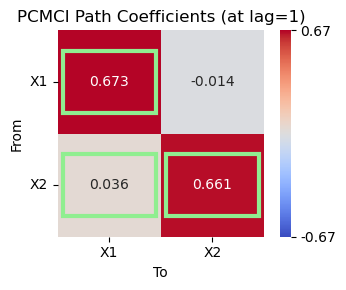

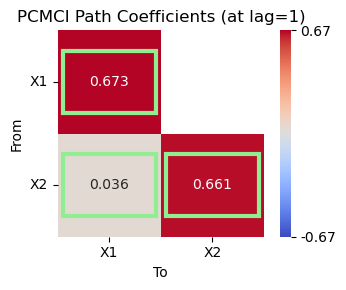

In [19]:
val1 = results['val_matrix'][:, :, 1]      # shape (2,2), coeff from j(t-1) → i(t)
p1   = q_matrix[:, :, 1]                  # FDR-corrected p-values at lag=1
alpha_level = 0.05
sig1 = (p1 < alpha_level)                 # True where link is significant
lim = np.max(np.abs(val1))
plot_heatmap(val1,title='PCMCI Path Coefficients (at lag=1)',vmin=-lim, vmax= lim, fmt=".3f",true_links=true_links_2d, figsize=(4,3))
plot_heatmap(val1,title='PCMCI Path Coefficients (at lag=1)',vmin=-lim, vmax= lim, fmt=".3f", annot_mask=sig1, true_links=true_links_2d, figsize=(4,3))


# 6D model

## LKIFR

In [20]:
load_series = True # True: load already saved time series (x,y,z); False: compute and save time series
load_var_results = False

filename = '../data/6D_series.npy'
var_filename = '../results/npy/6D_liang.npy'
if load_series == True: # load time series if indicated
    t, X1, X2, X3, X4, X5, X6 = np.load(filename,allow_pickle=True)
    true_links_6d = [(3, 4), (4, 3), (3,3), (0,1),(1,2),(2,0),(5,1),(5,5),(5,4)]  # format: (from, to)
if load_var_results:
    T, tau, R, error_T, error_tau, error_R, sig_T, sig_tau, sig_R = np.load(var_filename, allow_pickle=True)    

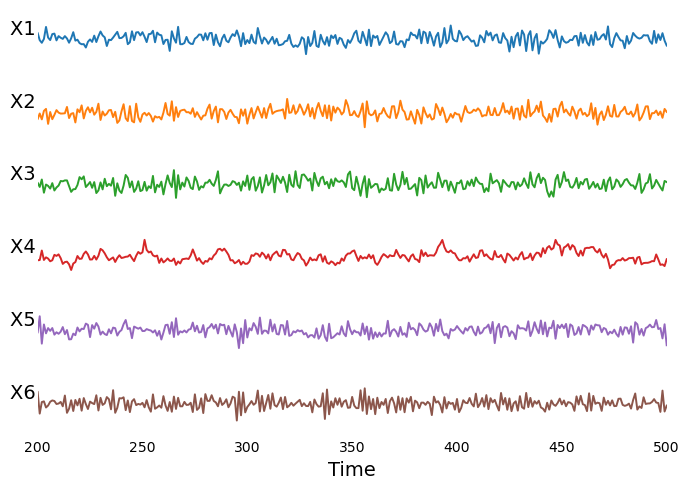

In [21]:
fig, axes = plt.subplots(6, 1, figsize=(7, 5), sharex=True)

# Time series list
series = [X1, X2, X3, X4, X5, X6]
labels = ['X1   ', 'X2   ', 'X3   ', 'X4   ', 'X5   ', 'X6   ']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

for i in range(6):
    axes[i].plot(t, series[i], color=colors[i], linewidth=1.4, label=labels[i])
    axes[i].set_ylabel(labels[i], rotation=0, size=14)
    axes[i].set_xlim(200, 500)

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].tick_params(left=False, labelleft=False, bottom=False)  # hides y-ticks and labels


# Set x-axis label only on bottom
axes[-1].set_xlabel('Time', size=14)

plt.tight_layout()
plt.show()

In [22]:
nvar_6d = 6 # number of variables (Liang [2021]: nvar=6)
n_iter = 400 # nuof bootstrap realizations (for computing the error in Liang index)
b_factor = 1 # amplitude of chaos
conf = 1.96 # 1.96 if 95% confidence interval; 2.58 if 99% confidence interval; 1.65 if 90% confidence interval

# Time parameters
dt = 1 # time step
tmax = 1.e6 # total duration in unit times
nt = int(tmax / dt) # number of time steps (Liang [2021]: nt=10000)
t = np.linspace(0,tmax,nt) # time vector (varying between 0 and tmax with nt time steps)
start_computation = int(10000 / dt) # exclude the first transient times for computing correlation coefficient and rate of information transfer

In [24]:
if load_series==False:
    # Simulate 6D Time Series
    alpha = np.array([0.1,0.7,0.5,0.2,0.8,0.3])
    A = np.array([(0, 0, -0.6, 0, 0, 0),
    			  (-0.5, 0, 0, 0, 0, 0.8),
    			  (0, 0.7, 0, 0, 0, 0),
    			  (0, 0, 0, 0.7, 0.4, 0),
    			  (0, 0, 0, 0.2, 0, 0.7),
    			  (0, 0, 0, 0, 0, -0.5)])
    B = np.ones(nvar) * b_factor

    # Random errors
    mean_e = 0
    std_e = 1
    e = np.zeros((nvar,nt))
    for var in np.arange(nvar):
        e[var,:] = np.random.normal(mean_e,std_e,nt)
    
    # Initialization of variables
    X = np.zeros((nvar,nt))
    T = np.zeros((nvar,nvar))
    tau = np.zeros((nvar,nvar))
    R = np.zeros((nvar,nvar))
    error_T = np.zeros((nvar,nvar))
    error_tau = np.zeros((nvar,nvar))
    error_R = np.zeros((nvar,nvar))

    # VAR model
    for i in np.arange(nt-1):
        for var in np.arange(nvar):
            X[var,i+1] = alpha[var] + np.sum(A[var,:] * X[:,i]) + B[var] * e[var,i+1]

    # Apply Liang-Kleeman Info Flow on Post-Transient Segment
    print('Computing the Information Flow Rate...')
    start_L6 = time.time()
    xx = np.array((X[0,start_computation::],
                   X[1,start_computation::],
                   X[2,start_computation::],
                   X[3,start_computation::],
                   X[4,start_computation::],
                   X[5,start_computation::]))
    T, tau, R, error_T, error_tau, error_R = compute_liang_nvar(xx, dt, n_iter)
    print(f"LKIFR computation time for 6D system: {time.time() - start_L6:.2f} seconds")
# else:
#     print(f'Significance testing on {var_filename}...')

Compute significance of rate of information transfer and correlation coefficient (by combining bootstrap samples)


In [6]:
# # Significance Check
# conf = 1.96  # for 95% confidence
# sig_T = np.zeros((nvar,nvar))
# sig_tau = np.zeros((nvar,nvar))
# sig_R = np.zeros((nvar,nvar))

# for j in np.arange(nvar):
#     for k in np.arange(nvar):
#         sig_T[j,k] = compute_sig(T[j,k],error_T[j,k],conf)
#         sig_tau[j,k] = compute_sig(tau[j,k],error_tau[j,k],conf)
#         sig_R[j,k] = compute_sig(R[j,k],error_R[j,k],conf)

if load_series==False:
    # Save time series and results
    np.save('../data/6D_series_new.npy',[t, X1, X2, X3, X4, X5, X6])
    np.save('../results/npy/6D_liang_new.npy',[T,tau,R,error_T,error_tau,error_R,sig_T,sig_tau,sig_R])

# Results
print("\nLiang-Kleeman Info Transfer (T) [6D]:")
print(T)
print("\nNormalized Info Transfer (% tau) [6D]:")
print(tau)
print("\nPearson Correlation (R) [6D]:")
print(R)

print("\nSignificance of T [6D]:")
print(sig_T)
print("\nSignificance of tau [6D]:")
print(sig_tau)
print("\nSignificance of R [6D]:")
print(sig_R)



Liang-Kleeman Info Transfer (T) [6D]:
[[-9.99813539e-01  1.22778826e-02  9.45702946e-06 -1.99191622e-07
   1.47526177e-05  2.13753791e-05]
 [-1.21380506e-06 -1.00221419e+00 -9.15105787e-02 -1.20269742e-05
   5.23070109e-04 -7.74923041e-05]
 [-3.88334326e-02 -6.16887429e-05 -9.99346085e-01 -3.59360638e-05
   7.44331306e-05 -1.05505787e-04]
 [-9.43335953e-08  2.71796218e-05  3.12757633e-05 -2.99194938e-01
   3.70673050e-02 -3.99155694e-05]
 [-4.70135792e-05  3.91032358e-04  2.54368927e-04  4.57433271e-02
  -1.00229140e+00  1.67191010e-05]
 [-2.82393700e-05 -1.84482243e-01 -7.70080075e-05 -1.70598690e-05
  -1.85379191e-01 -1.49975035e+00]]

Normalized Info Transfer (% tau) [6D]:
[[-7.55675946e+01  8.62996499e-01  7.11341667e-04 -3.84588206e-05
   9.80053335e-04  1.13999479e-03]
 [-9.17414346e-05 -7.04443398e+01 -6.88327006e+00 -2.32210189e-03
   3.47488572e-02 -4.13283072e-03]
 [-2.93509638e+00 -4.33602200e-03 -7.51691124e+01 -6.93833713e-03
   4.94477926e-03 -5.62684981e-03]
 [-7.129892

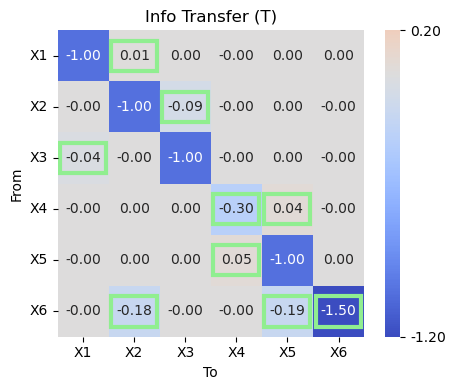

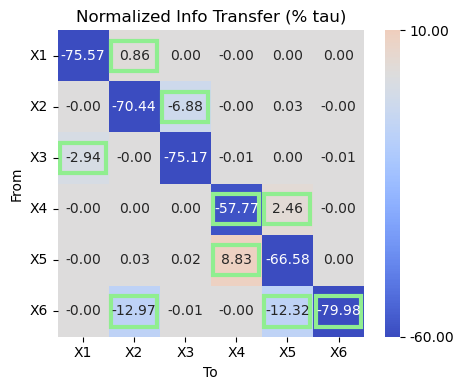

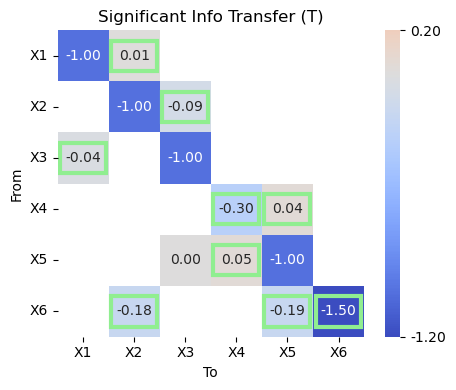

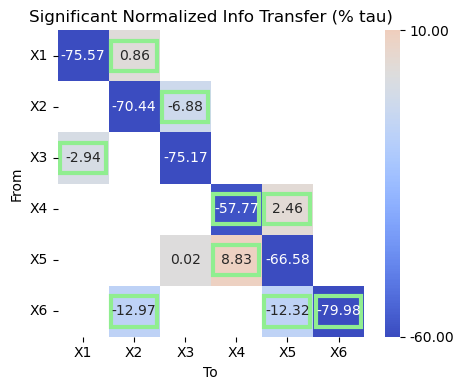

In [8]:
true_links_6d = [(3, 4), (4, 3), (3,3), (0,1),(1,2),(2,0),(5,1),(5,5),(5,4)]  # format: (from, to)
plot_heatmap(T, title='Info Transfer (T)', vmin=-1.2, vmax=0.2, true_links=true_links_6d)
plot_heatmap(tau, title='Normalized Info Transfer (% tau)', vmin=-60, vmax=10, true_links=true_links_6d)

# Plot significant 
plot_heatmap(T * sig_T, title='Significant Info Transfer (T)', vmin=-1.2, vmax=0.2, annot_mask=sig_T, true_links=true_links_6d)
plot_heatmap(tau * sig_tau, title='Significant Normalized Info Transfer (% tau)', vmin=-60, vmax=10, annot_mask=sig_tau, true_links=true_links_6d)

#### aligned with matlab code 
takes approx 15 minutes

In [9]:
dt = 0.001
start_computation = int(10 / dt)  # discard transients
from function_liang import compute_liang
start_L2 = time.time()
xx = np.array((X1[start_computation:], X2[start_computation:], X3[start_computation:],
               X4[start_computation:], X5[start_computation:], X6[start_computation:]))
T, tau, R, error_T, error_tau, error_R, sig_T, sig_tau = compute_liang(
    xx,
    dt=0.001,
    n_iter=200,            # number of permutations
    method='permutation',
    return_sig=True,
    alpha=5                 # 5% significance
)
print(f"LKIFR with permutation test computation time: {time.time() - start_L2:.2f} seconds")
print("T\n", T)
print("tau\n", tau)
print("sig_T\n", sig_T)
print("sig_tau\n", sig_tau)

LKIFR with permutation test computation time: 861.27 seconds
T
 [[-9.99812529e+02  1.22778702e+01  9.45701990e-03 -1.99191421e-04
   1.47526028e-02  2.13753575e-02]
 [-1.21380383e-03 -1.00221318e+03 -9.15104863e+01 -1.20269620e-02
   5.23069581e-01 -7.74922259e-02]
 [-3.88333934e+01 -6.16886806e-02 -9.99345075e+02 -3.59360275e-02
   7.44330554e-02 -1.05505680e-01]
 [-9.43335000e-05  2.71795944e-02  3.12757317e-02 -2.99194636e+02
   3.70672675e+01 -3.99155290e-02]
 [-4.70135318e-02  3.91031963e-01  2.54368670e-01  4.57432809e+01
  -1.00229038e+03  1.67190841e-02]
 [-2.82393415e-02 -1.84482057e+02 -7.70079297e-02 -1.70598518e-02
  -1.85379004e+02 -1.49974883e+03]]
tau
 [[-7.55675782e+01  8.62996362e-01  7.11341539e-04 -3.84588077e-05
   9.80053150e-04  1.13999456e-03]
 [-9.17414147e-05 -7.04443286e+01 -6.88326881e+00 -2.32210111e-03
   3.47488507e-02 -4.13282988e-03]
 [-2.93509574e+00 -4.33602131e-03 -7.51690988e+01 -6.93833479e-03
   4.94477833e-03 -5.62684867e-03]
 [-7.12989079e-06  1.

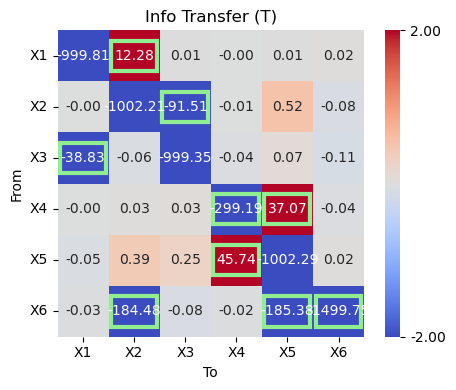

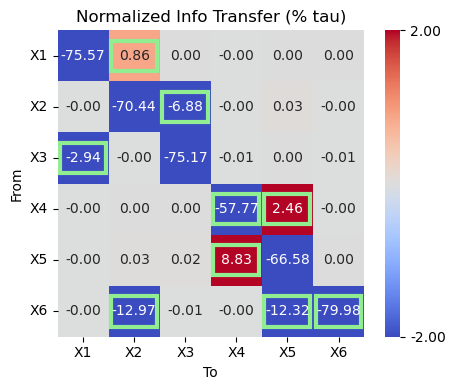

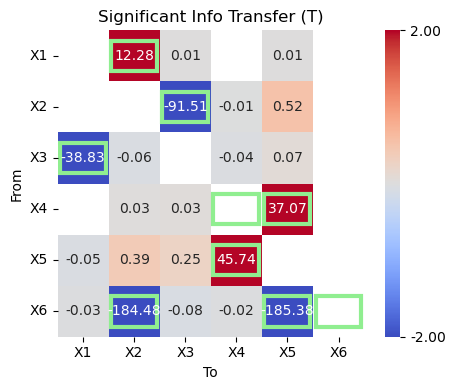

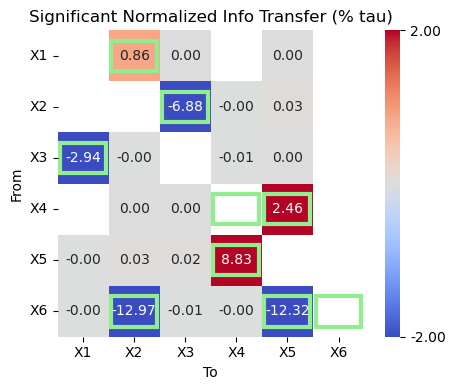

In [14]:
true_links_6d = [(3, 4), (4, 3), (3,3), (0,1),(1,2),(2,0),(5,1),(5,5),(5,4)]  # format: (from, to)
plot_heatmap(T, title='Info Transfer (T)', vmin=-2., vmax=2., true_links=true_links_6d)
plot_heatmap(tau, title='Normalized Info Transfer (% tau)', vmin=-2, vmax=2, true_links=true_links_6d)

# Plot significant 
plot_heatmap(T * sig_T, title='Significant Info Transfer (T)', vmin=-2, vmax=2, annot_mask=sig_T, true_links=true_links_6d)
plot_heatmap(tau * sig_tau, title='Significant Normalized Info Transfer (% tau)', vmin=-2, vmax=2, annot_mask=sig_tau, true_links=true_links_6d)

## PCMCI

In [25]:
data_6d_cut = np.array([X1[start_computation:], X2[start_computation:], X3[start_computation:], 
                        X4[start_computation:], X5[start_computation:], X6[start_computation:]]).T  # shape: (T, 6)

dataframe_6d = DataFrame(data_6d_cut, var_names=[f"X{i+1}" for i in range(nvar_6d)])

# Setting up ParCorr test and PCMCI object with TIGRAMITE
parcorr = ParCorr(significance='analytic')
alpha_level = 0.05
tau_max = 3
pcmci_6d = PCMCI(dataframe=dataframe_6d, cond_ind_test=parcorr)

# Running PCMCI (may take several minutes)
results_6d = pcmci_6d.run_pcmci(tau_max=tau_max, pc_alpha=alpha_level)

# FDR-corrected p-values
q_matrix_6d = pcmci_6d.get_corrected_pvalues(p_matrix=results_6d['p_matrix'], fdr_method='fdr_bh')
significant_6d = q_matrix_6d < alpha_level # we store for plotting

# Retrieving inferred parents from graph (but we'll use the FDR corrected values)
parents_dict_6d = pcmci_6d.return_parents_dict(graph=results_6d['graph'], val_matrix=results_6d['val_matrix'])

# Printing results_6d ##########
print(f'Note: Alpha level {alpha_level} means accepting a {alpha_level*100:.1f}% chance of falsely detecting a link that is not true.')
pcmci_6d.print_significant_links(p_matrix = q_matrix_6d, val_matrix = results_6d['val_matrix'], alpha_level = alpha_level)
graph = pcmci_6d.get_graph_from_pmatrix(p_matrix=q_matrix_6d, alpha_level=alpha_level, tau_min=0, tau_max=tau_max, link_assumptions=None)
results_6d['graph'] = graph

# Retrieving inferred parents from above (corrected) graph
parents_dict_6d = pcmci_6d.return_parents_dict(graph=results_6d['graph'], val_matrix=results_6d['val_matrix'])

# Show beta (path coefficients) matrix at lag 1
print("\nPCMCI Path Coefficients (val_matrix) at lag=1:")
print(' ', results_6d['val_matrix'][:, :, 1])

print("\nInferred parents per variable (from graph):")
for var, parents in parents_dict_6d.items():
    varname = dataframe_6d.var_names[var]
    formatted = ', '.join(f"{dataframe_6d.var_names[pv]}(t{lag})" for pv, lag in parents)
    print(f"  {varname}(t) ← {formatted}")

Note: Alpha level 0.05 means accepting a 5.0% chance of falsely detecting a link that is not true.

## Significant links at alpha = 0.05:

    Variable X1 has 1 link(s):
        (X3 -1): pval = 0.00000 | val = -0.515

    Variable X2 has 2 link(s):
        (X6 -1): pval = 0.00000 | val =  0.624
        (X1 -1): pval = 0.00000 | val = -0.446

    Variable X3 has 1 link(s):
        (X2 -1): pval = 0.00000 | val =  0.574

    Variable X4 has 2 link(s):
        (X4 -1): pval = 0.00000 | val =  0.573
        (X5 -1): pval = 0.00000 | val =  0.370

    Variable X5 has 2 link(s):
        (X6 -1): pval = 0.00000 | val =  0.573
        (X4 -1): pval = 0.00000 | val =  0.196

    Variable X6 has 1 link(s):
        (X6 -1): pval = 0.00000 | val = -0.447

PCMCI Path Coefficients (val_matrix) at lag=1:
  [[ 8.48694301e-04 -4.46229470e-01 -5.28553795e-04  1.97383506e-04
   5.08949336e-05  1.13028479e-03]
 [ 4.09408318e-04 -2.51196331e-03  5.73575503e-01 -7.01450196e-04
   2.25518029e-03  8.68378565e

#### Draft Plotting 

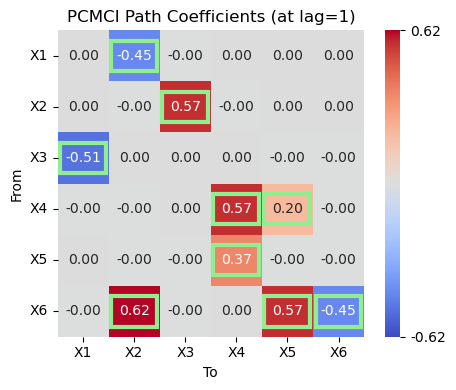

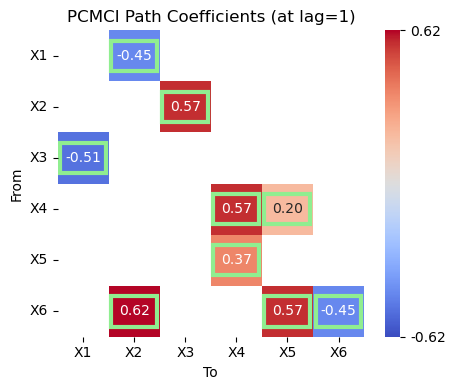

In [32]:
true_links_6d = [(3, 4), (4, 3), (3,3), (0,1),(1,2),(2,0),(5,1),(5,5),(5,4)]  # format: (from, to)
val1_matrix_6d = results_6d['val_matrix'][:, :, 1]      # shape (6,6), coeff from j(t-1) → i(t)
p1_6d   = q_matrix_6d[:, :, 1]                  # FDR-corrected p-values at lag=1
alpha_level = 0.05
sig1_links = (p1_6d < alpha_level)                 # True where link is significant
lim = np.max(np.abs(val1_matrix_6d))
plot_heatmap(val1_matrix_6d,title='PCMCI Path Coefficients (at lag=1)',vmin=-lim, vmax= lim, fmt=".2f",true_links=true_links_6d, figsize=(5,4))
plot_heatmap(val1_matrix_6d,title='PCMCI Path Coefficients (at lag=1)',vmin=-lim, vmax= lim, fmt=".2f", annot_mask=sig1_links, true_links=true_links_6d, figsize=(5,4))


# Real Data

## LKIFR

### CO2 NOAA-deseasoned, Temp plain average

The attempt below uses the deseasonalized CO2 data from Mauna Loa, preprocessed by NOAA. Its deseasoning process uses a digial filter and the seasonal component is estimated using a nontlinear iterative curve fitting method (Thoning et al. 1989). The temperature dataset uses monthly mean, firstly without de-seasonining.

In [2]:
df = pd.read_pickle("../data/temp_co2_aligned.pkl")
df

,temperature,co2
1958-03-01,5.110323,314.44
1958-04-01,8.125792,315.16
1958-05-01,11.181393,314.69
1958-06-01,12.985923,315.15
1958-07-01,14.422375,315.20
...,...,...
2025-01-01,4.449924,426.35
2025-02-01,4.444533,426.15
2025-03-01,6.837699,426.69
2025-04-01,9.779043,427.13


In [3]:
temp = df.iloc[:,0].values
co2 = df.iloc[:,1].values
dt = 1/12
n_iter=200
xx = np.array([temp, co2])


print("Computing LKIFR...")
start = time.time()
T, tau, R, error_T, error_tau, error_R = compute_liang_nvar(xx, dt, n_iter)
print(f"Process took {time.time() - start:.2f} sec")

# Significance
nvar = 2
alpha_level = 0.05
conf = norm.ppf(1 - alpha_level / 2)

sig_T = np.zeros((nvar, nvar))
sig_tau = np.zeros((nvar, nvar))
sig_R = np.zeros((nvar, nvar))

for j in range(nvar):
    for k in range(nvar):
        sig_T[j, k] = compute_sig(T[j, k], error_T[j, k], conf)
        sig_tau[j, k] = compute_sig(tau[j, k], error_tau[j, k], conf)
        sig_R[j, k] = compute_sig(R[j, k], error_R[j, k], conf)

# Print results
print("\nLiang-Kleeman Info Transfer (T):")
print(T)
print("\nNormalized Info Transfer (% tau):")
print(tau)
print("\nPearson Correlation (R):")
print(R)
print(f"\n\nFor alpha_level = {alpha_level}:")
print("\nSignificance of T (1=significant):")
print(sig_T)
print("\nSignificance of tau:")
print(sig_tau)

Computing LKIFR...
Process took 0.95 sec

Liang-Kleeman Info Transfer (T):
[[-1.64638029e+00  2.08293056e-04]
 [ 1.98308327e-02  1.62946352e-02]]

Normalized Info Transfer (% tau):
[[-51.78627763   1.22161517]
 [  0.62377144  95.56618877]]

Pearson Correlation (R):
[[1.         0.10937683]
 [0.10937683 1.        ]]


For alpha_level = 0.05:

Significance of T (1=significant):
[[1. 0.]
 [0. 1.]]

Significance of tau:
[[1. 0.]
 [0. 1.]]


### CO2 and Temp equivalently deseasoned datasets:

The process below uses the monthly average [CO2] data from Mauna Loa, and the global monthly mean temperature both preprocessed as follows: each month had its mean subtracted, then, annual differences were applied to obtain deseasoned datasets.

In [2]:
df_desed = pd.read_pickle("../data/temp_co2_aligned_deeasoned.pkl") # "desed" for deseasoned
df_desed

,temperature_deseasoned,co2_deseasoned
1959-03-01,0.330670,0.94
1959-04-01,0.294811,0.27
1959-05-01,-0.400817,0.78
1959-06-01,0.376145,0.88
1959-07-01,0.123718,0.67
...,...,...
2025-01-01,0.626188,3.85
2025-02-01,-0.290660,2.54
2025-03-01,-0.167666,2.77
2025-04-01,0.053675,3.13


In [16]:
temp_desed = df_desed.iloc[:,0].values
co2_desed = df_desed.iloc[:,1].values
dt = 1/12
n_iter=1000
xx = np.array([temp_desed, co2_desed])

print("Computing LKIFR...")
start = time.time()
T, tau, R, error_T, error_tau, error_R = compute_liang_nvar(xx, dt, n_iter)
print(f"Process took {time.time() - start:.2f} sec")

# Computing the significance
nvar = 2
alpha_level = 0.03
conf = norm.ppf(1 - alpha_level / 2)
sig_T = np.zeros((nvar, nvar))
sig_tau = np.zeros((nvar, nvar))
sig_R = np.zeros((nvar, nvar))

for j in range(nvar):
    for k in range(nvar):
        sig_T[j, k] = compute_sig(T[j, k], error_T[j, k], conf)
        sig_tau[j, k] = compute_sig(tau[j, k], error_tau[j, k], conf)
        sig_R[j, k] = compute_sig(R[j, k], error_R[j, k], conf)

# Printing the results
print("\nLiang-Kleeman Info Transfer (T):")
print(T)
print("\nNormalized Info Transfer (% tau):")
print(tau)
print("\nPearson Correlation (R):")
print(R)
print(f"\n\nFor alpha_level = {alpha_level}:")
print("\nSignificance of T (1=significant):")
print(sig_T)
print("\nSignificance of tau:")
print(sig_tau)

Computing LKIFR...
Process took 1.19 sec

Liang-Kleeman Info Transfer (T):
[[-7.12974353  0.08602232]
 [ 0.13357561 -1.75415733]]

Normalized Info Transfer (% tau):
[[-58.54139274   2.52067915]
 [  1.09677191 -51.40140271]]

Pearson Correlation (R):
[[1.         0.15037915]
 [0.15037915 1.        ]]


For alpha_level = 0.03:

Significance of T (1=significant):
[[1. 0.]
 [0. 1.]]

Significance of tau:
[[1. 1.]
 [0. 1.]]


In [17]:
def significance_stability_test(x, dt, n_iter=1000, alpha_level=0.03, n_trials=100):
    nvar = x.shape[0]
    z = norm.ppf(1 - alpha_level / 2)

    sig_count_T = np.zeros((nvar, nvar))
    sig_count_tau = np.zeros((nvar, nvar))

    for trial in range(n_trials):
        T, tau, _, error_T, error_tau, _ = compute_liang_nvar(x, dt, n_iter)

        for i in range(nvar):
            for j in range(nvar):
                sig_T = compute_sig(T[j, i], error_T[j, i], z)
                sig_tau = compute_sig(tau[j, i], error_tau[j, i], z)
                sig_count_T[j, i] += sig_T
                sig_count_tau[j, i] += sig_tau

    sig_rate_T = 100 * sig_count_T / n_trials  # converting to percentages in case n_trials is not 100
    sig_rate_tau = 100 * sig_count_tau / n_trials

    return sig_rate_T, sig_rate_tau


In [18]:
xx = np.array([temp_desed, co2_desed])
dt = 1/12
sig_rate_T, sig_rate_tau = significance_stability_test(xx, dt, n_iter=500, alpha_level=0.03, n_trials=100)

print("T significance rates (%):")
print(sig_rate_T)

print("\nTau significance rates (%):")
print(sig_rate_tau)

T Significance Rates (%):
[[100.  67.]
 [ 26. 100.]]

Tau Significance Rates (%):
[[100.  83.]
 [ 49. 100.]]


#### LKIFR with lag

In [19]:
max_lag = 6
dt = 1/12
n_iter = 500
T_lagged = []
tau_lagged = []

for lag in range(0, max_lag + 1):
    temp_shifted = np.roll(temp_desed, -lag)  # shifting temp forward by `lag` steps
    temp_shifted[:lag] = np.nan  # Remove wrap-around contamination

    xx = np.array([temp_shifted, co2_desed]) #stacking the shifted temperature with co2

    valid_idx = ~np.isnan(xx).any(axis=0) #removing rows with NaNs
    xx_valid = xx[:, valid_idx]

    T, tau, *_ = compute_liang_nvar(xx_valid, dt, n_iter) #computing LKIF
    
    T_lagged.append(T.copy())
    tau_lagged.append(tau.copy())

T_lagged = np.array(T_lagged)  # converting to numpy arrays
tau_lagged = np.array(tau_lagged)


In [26]:
def lagged_liang_with_stability(temp_desed, co2_desed, max_lag=6, dt=1/12, n_iter=500, alpha_level=0.03, n_trials=100):
    from scipy.stats import norm

    nvar = 2
    z = norm.ppf(1 - alpha_level / 2)

    T_lagged = []
    tau_lagged = []
    error_T_lagged = []
    error_tau_lagged = []
    sig_rate_T_lagged = []
    sig_rate_tau_lagged = []

    for lag in range(0, max_lag + 1):
        temp_shifted = np.roll(temp_desed, -lag)
        temp_shifted[:lag] = np.nan

        xx = np.array([temp_shifted, co2_desed])
        valid_idx = ~np.isnan(xx).any(axis=0)
        xx_valid = xx[:, valid_idx]

        T, tau, _, error_T, error_tau, _ = compute_liang_nvar(xx_valid, dt, n_iter)

        # Store the basic outputs
        T_lagged.append(T)
        tau_lagged.append(tau)
        error_T_lagged.append(error_T)
        error_tau_lagged.append(error_tau)

        # Compute significance stability rates for this lag
        sig_count_T = np.zeros((nvar, nvar))
        sig_count_tau = np.zeros((nvar, nvar))

        for trial in range(n_trials):
            T_trial, tau_trial, _, err_T_trial, err_tau_trial, _ = compute_liang_nvar(xx_valid, dt, n_iter)
            for i in range(nvar):
                for j in range(nvar):
                    sig_T = compute_sig(T_trial[j, i], err_T_trial[j, i], z)
                    sig_tau = compute_sig(tau_trial[j, i], err_tau_trial[j, i], z)
                    sig_count_T[j, i] += sig_T
                    sig_count_tau[j, i] += sig_tau

        sig_rate_T_lagged.append(sig_count_T * 100 / n_trials)
        sig_rate_tau_lagged.append(sig_count_tau * 100 / n_trials)

    # Convert lists to arrays of shape (n_lags, nvar, nvar)
    T_lagged = np.array(T_lagged)
    tau_lagged = np.array(tau_lagged)
    error_T_lagged = np.array(error_T_lagged)
    error_tau_lagged = np.array(error_tau_lagged)
    sig_rate_T_lagged = np.array(sig_rate_T_lagged)
    sig_rate_tau_lagged = np.array(sig_rate_tau_lagged)

    return T_lagged, tau_lagged, error_T_lagged, error_tau_lagged, sig_rate_T_lagged, sig_rate_tau_lagged


In [27]:
T_lagged, tau_lagged, error_T_lagged, error_tau_lagged, sig_rate_T_lagged, sig_rate_tau_lagged = \
    lagged_liang_with_stability(temp_desed, co2_desed, max_lag=6, dt=1/12, n_iter=500, alpha_level=0.03, n_trials=100)


In [28]:
sig_rate_T_lagged

array([[[100.,  63.],
        [ 29., 100.]],

       [[100.,   0.],
        [  0., 100.]],

       [[100.,  55.],
        [  0., 100.]],

       [[100.,   0.],
        [  0., 100.]],

       [[100.,   0.],
        [  0., 100.]],

       [[100.,   0.],
        [  0., 100.]],

       [[100.,   0.],
        [  0., 100.]]])

In [29]:
sig_rate_tau_lagged

array([[[100.,  89.],
        [ 54., 100.]],

       [[100.,   0.],
        [  0., 100.]],

       [[100.,  71.],
        [  0., 100.]],

       [[100.,   0.],
        [  0., 100.]],

       [[100.,   0.],
        [  0., 100.]],

       [[100.,   0.],
        [  0., 100.]],

       [[100.,   0.],
        [  0., 100.]]])

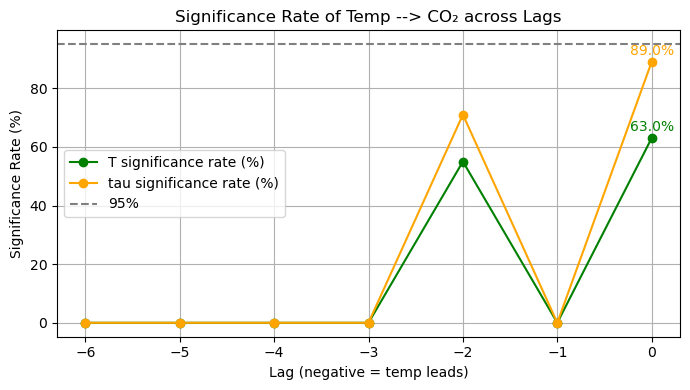

In [40]:
lags = -np.arange(sig_rate_T_lagged.shape[0])  # negative = Temp leads

peak_idx_T = np.argmax(sig_rate_T_lagged[:, 0, 1])
peak_idx_tau = np.argmax(sig_rate_tau_lagged[:, 0, 1])
x_T, y_T = lags[peak_idx_T], sig_rate_T_lagged[peak_idx_T, 0, 1]
x_tau, y_tau = lags[peak_idx_tau], sig_rate_tau_lagged[peak_idx_tau, 0, 1]

plt.figure(figsize=(7, 4))
plt.plot(lags, sig_rate_T_lagged[:, 0, 1], '-o', label='T significance rate (%)', color='green')
plt.plot(lags, sig_rate_tau_lagged[:, 0, 1], '-o', label='tau significance rate (%)', color='orange')
plt.axhline(95, color='gray', linestyle='--', label='95%')
plt.title("Significance Rate of Temp --> CO₂ across Lags")
plt.xlabel("Lag (negative = temp leads)")
plt.ylabel("Significance Rate (%)")
plt.legend()

plt.annotate(f'{y_T:.1f}%', (x_T, y_T), textcoords="offset points", xytext=(0,5), ha='center', color='green')
plt.annotate(f'{y_tau:.1f}%', (x_tau, y_tau), textcoords="offset points", xytext=(0,5), ha='center', color='orange')

plt.grid(True)
plt.tight_layout()
plt.show()


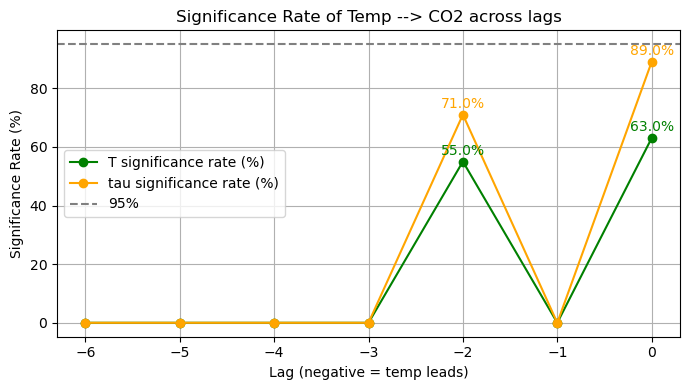

In [58]:
from scipy.signal import find_peaks
interesting_lags = [0, -2]

# Extract the significance series
sig_T = sig_rate_T_lagged[:, 0, 1]
sig_tau = sig_rate_tau_lagged[:, 0, 1]

# Lags are negative (Temp leads)
lags = -np.arange(sig_T.shape[0])

# Find peaks
peaks_T, _ = find_peaks(sig_T, prominence=0.01)   # tweak 'prominence' as needed
peaks_tau, _ = find_peaks(sig_tau, prominence=0.01)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(lags, sig_T, '-o', label='T significance rate (%)', color='green')
plt.plot(lags, sig_tau, '-o', label='tau significance rate (%)', color='orange')
plt.axhline(95, color='gray', linestyle='--', label='95%')

for lag in interesting_lags:
    idx = np.where(lags == lag)[0][0]
    val = sig_T[idx]
    val2 = sig_tau[idx]
    plt.annotate(f'{val:.1f}%', (lag, val), textcoords="offset points", xytext=(0, 5), ha='center', color='green')
    plt.annotate(f'{val2:.1f}%', (lag, val2), textcoords="offset points", xytext=(0, 5), ha='center', color='orange')


plt.title("Significance Rate of Temp --> CO2 across lags")
plt.xlabel("Lag (negative = temp leads)")
plt.ylabel("Significance Rate (%)")
plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from scipy.signal import find_peaks
interesting_lags = [0, -2]

# Extract the significance series
sig_T = sig_rate_T_lagged[:, 0, 1]
sig_tau = sig_rate_tau_lagged[:, 0, 1]

# Lags are negative (Temp leads)
lags = -np.arange(sig_T.shape[0])

# Find peaks
peaks_T, _ = find_peaks(sig_T, prominence=0.01)   # tweak 'prominence' as needed
peaks_tau, _ = find_peaks(sig_tau, prominence=0.01)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(lags, sig_T, '-o', label='T significance rate (%)', color='green')
plt.plot(lags, sig_tau, '-o', label='tau significance rate (%)', color='orange')
plt.axhline(95, color='gray', linestyle='--', label='95%')

for lag in interesting_lags:
    idx = np.where(lags == lag)[0][0]
    val = sig_T[idx]
    val2 = sig_tau[idx]
    plt.annotate(f'{val:.1f}%', (lag, val), textcoords="offset points", xytext=(0, 5), ha='center', color='green')
    plt.annotate(f'{val2:.1f}%', (lag, val2), textcoords="offset points", xytext=(0, 5), ha='center', color='orange')


plt.title("Significance Rate of Temp --> CO2 across lags")
plt.xlabel("Lag (negative = temp leads)")
plt.ylabel("Significance Rate (%)")
plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()


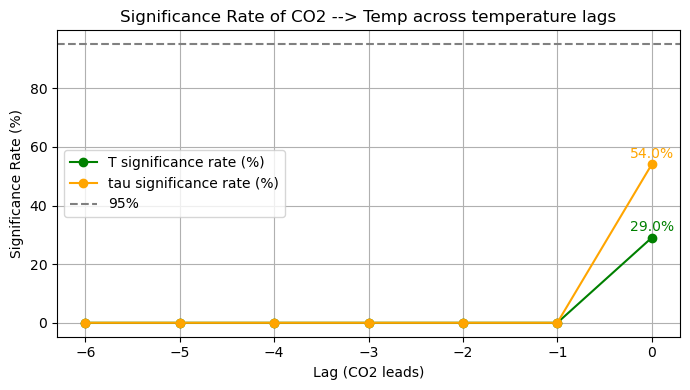

In [62]:
from scipy.signal import find_peaks
interesting_lags = [0]

# Extract the significance series for CO₂ → Temp
sig_T = sig_rate_T_lagged[:, 1, 0]
sig_tau = sig_rate_tau_lagged[:, 1, 0]

# Lags are negative (CO₂ leads)
lags = -np.arange(sig_T.shape[0])


plt.figure(figsize=(7, 4))
plt.plot(lags, sig_T, '-o', label='T significance rate (%)', color='green')
plt.plot(lags, sig_tau, '-o', label='tau significance rate (%)', color='orange')
plt.axhline(95, color='gray', linestyle='--', label='95%')

for lag in interesting_lags:
    idx = np.where(lags == lag)[0][0]
    val = sig_T[idx]
    val2 = sig_tau[idx]
    plt.annotate(f'{val:.1f}%', (lag, val), textcoords="offset points", xytext=(0, 5), ha='center', color='green')
    plt.annotate(f'{val2:.1f}%', (lag, val2), textcoords="offset points", xytext=(0, 5), ha='center', color='orange')

plt.title("Significance Rate of CO2 --> Temp across temperature lags")
plt.xlabel("Lag (CO2 leads)")
plt.ylabel("Significance Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### CO2 and Temp equivalently deseasoned Matlab aligned:

In [33]:
df_desed = pd.read_pickle("../data/temp_co2_aligned_deeasoned.pkl") # "desed" for deseasoned
df_desed

,temperature_deseasoned,co2_deseasoned
1959-03-01,0.330670,0.94
1959-04-01,0.294811,0.27
1959-05-01,-0.400817,0.78
1959-06-01,0.376145,0.88
1959-07-01,0.123718,0.67
...,...,...
2025-01-01,0.626188,3.85
2025-02-01,-0.290660,2.54
2025-03-01,-0.167666,2.77
2025-04-01,0.053675,3.13


In [63]:
temp_desed = df_desed.iloc[:,0].values
co2_desed = df_desed.iloc[:,1].values
dt = 1/12
n_iter=1000
xx = np.array([temp_desed, co2_desed])

print("Computing LKIFR...")
start = time.time()
T, tau, R, error_T, error_tau, error_R, sig_T,sig_tau = compute_liang(xx, dt, n_iter, method='permutation', 
                                                                      return_sig=True, alpha=0.99)
print(f"Process took {time.time() - start:.2f} sec")

print(f"LKIFR with permutation test computation time: {time.time() - start_L2:.2f} seconds")
print("T\n", T)
print("tau\n", tau)
print("sig_T\n", sig_T)
print("sig_tau\n", sig_tau)

Computing LKIFR...
Process took 2.75 sec
LKIFR with permutation test computation time: 8665.93 seconds
T
 [[-7.1207753   0.08591411]
 [ 0.13340759 -1.75195084]]
tau
 [[-58.51163346   2.51921703]
 [  1.09621437 -51.37158734]]
sig_T
 [[0 1]
 [0 0]]
sig_tau
 [[0 1]
 [0 0]]


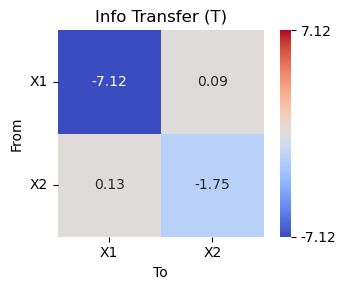

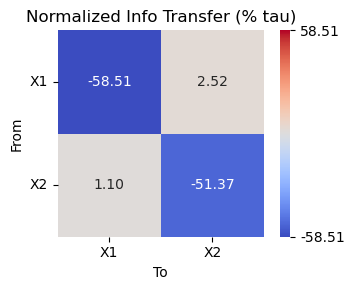

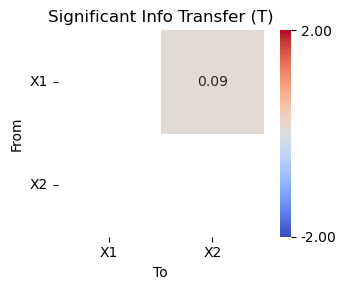

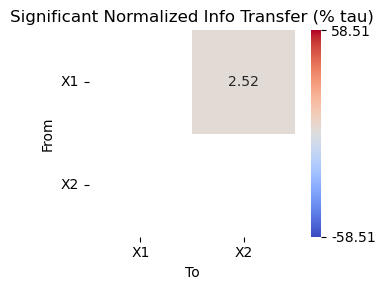

In [64]:
limT = np.max(np.abs(T))
limt = np.max(np.abs(tau))
plot_heatmap(T, title='Info Transfer (T)', vmin=-limT, vmax=limT, figsize=(4,3))
plot_heatmap(tau, title='Normalized Info Transfer (% tau)', vmin=-limt, vmax=limt, figsize=(4,3))

# Plot significant only
plot_heatmap(T * sig_T, title='Significant Info Transfer (T)', vmin=-2, vmax=2, annot_mask=sig_T, figsize=(4,3))
plot_heatmap(tau * sig_tau, title='Significant Normalized Info Transfer (% tau)', vmin=-limt, vmax=limt, annot_mask=sig_tau, figsize=(4,3))


In [61]:
# Computing the significance
nvar = 2
alpha_level = 0.05
conf = norm.ppf(1 - alpha_level / 2)
sig_T = np.zeros((nvar, nvar))
sig_tau = np.zeros((nvar, nvar))
sig_R = np.zeros((nvar, nvar))

for j in range(nvar):
    for k in range(nvar):
        sig_T[j, k] = compute_sig(T[j, k], error_T[j, k], conf)
        sig_tau[j, k] = compute_sig(tau[j, k], error_tau[j, k], conf)
        sig_R[j, k] = compute_sig(R[j, k], error_R[j, k], conf)

# Printing the results
print("\nLiang-Kleeman Info Transfer (T):")
print(T)
print("\nNormalized Info Transfer (% tau):")
print(tau)
print("\nPearson Correlation (R):")
print(R)
print(f"\n\nFor alpha_level = {alpha_level}:")
print("\nSignificance of T (1=significant):")
print(sig_T)
print("\nSignificance of tau:")
print(sig_tau)


Liang-Kleeman Info Transfer (T):
[[-7.1207753   0.08591411]
 [ 0.13340759 -1.75195084]]

Normalized Info Transfer (% tau):
[[-58.51163346   2.51921703]
 [  1.09621437 -51.37158734]]

Pearson Correlation (R):
[[1.         0.15037915]
 [0.15037915 1.        ]]


For alpha_level = 0.05:

Significance of T (1=significant):
[[1. 1.]
 [1. 1.]]

Significance of tau:
[[1. 1.]
 [1. 1.]]


## PCMCI

#### CO2 NOAA-deseasoned, Temp plain

In [ ]:
# NOT YET IMPLEMENTED

#### CO2 and Temp equivalently deseasoned

In [65]:
df_desed = pd.read_pickle("../data/temp_co2_aligned_deeasoned.pkl") # "desed" for deseasoned
data_array = df_desed.to_numpy()

In [66]:
df_desed = DataFrame(data_array, var_names=["temp", "co2"])

# Setting up ParCorr test and PCMCI object
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=df_desed, cond_ind_test=parcorr)
alpha_level = 0.034
tau_max = 4
# Running PCMCI 
results = pcmci.run_pcmci(tau_max=4, pc_alpha=alpha_level)

# Working the FDR-corrected p-values
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')


# Printing results ##########
print(f'Note: Alpha level {alpha_level} means accepting a {alpha_level*100:.1f}% chance of falsely detecting a link that is not true.')
pcmci.print_significant_links(p_matrix = q_matrix, val_matrix = results['val_matrix'], alpha_level = alpha_level)
graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=alpha_level, tau_min=0, tau_max=tau_max, link_assumptions=None)
results['graph'] = graph

# Retrieving inferred parents from above (corrected) graph
parents_dict = pcmci.return_parents_dict(graph=results['graph'], val_matrix=results['val_matrix'])

# Show beta (path coefficients) matrix at lag 1
print("\nPCMCI Path Coefficients (val_matrix) at lag=1:")
print(' ', results['val_matrix'][:, :, 1])

print("\nInferred parents per variable (from graph):")
for var, parents in parents_dict.items():
    varname = df_desed.var_names[var]
    formatted = ', '.join(f"{df_desed.var_names[pv]}(t{lag})" for pv, lag in parents)
    print(f"  {varname}(t) ← {formatted}")



Note: Alpha level 0.034 means accepting a 3.4% chance of falsely detecting a link that is not true.

## Significant links at alpha = 0.034:

    Variable temp has 2 link(s):
        (temp -1): pval = 0.00000 | val =  0.313
        (temp -2): pval = 0.00000 | val =  0.189

    Variable co2 has 3 link(s):
        (co2 -1): pval = 0.00000 | val =  0.511
        (temp -2): pval = 0.00192 | val =  0.125
        (co2 -2): pval = 0.00623 | val =  0.111

PCMCI Path Coefficients (val_matrix) at lag=1:
  [[0.31328266 0.03492484]
 [0.08223849 0.51108859]]

Inferred parents per variable (from graph):
  temp(t) ← temp(t-1), temp(t-2)
  co2(t) ← co2(t-1), temp(t-2), co2(t-2)


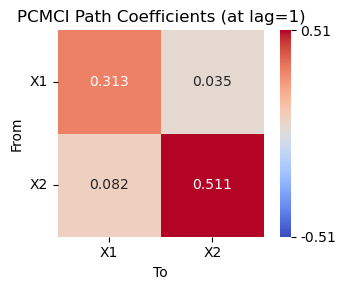

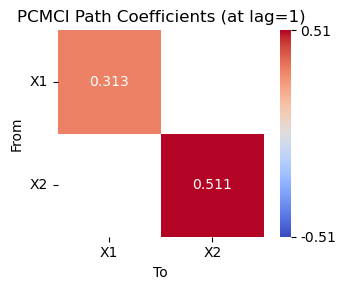

In [68]:
val1 = results['val_matrix'][:, :, 1]      # shape (2,2), coeff from j(t-1) → i(t)
p1   = q_matrix[:, :, 1]                  # FDR-corrected p-values at lag=1
alpha_level = 0.05
sig1 = (p1 < alpha_level)                 # True where link is significant
lim = np.max(np.abs(val1))
plot_heatmap(val1,title='PCMCI Path Coefficients (at lag=1)',vmin=-lim, vmax= lim, fmt=".3f", figsize=(4,3))
plot_heatmap(val1,title='PCMCI Path Coefficients (at lag=1)',vmin=-lim, vmax= lim, fmt=".3f", annot_mask=sig1, figsize=(4,3))


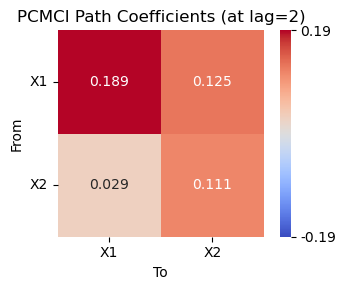

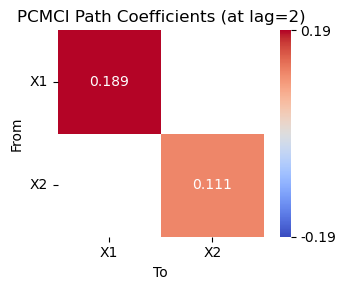

In [69]:
val2 = results['val_matrix'][:, :, 2]      # shape (2,2), coeff from j(t-2) → i(t)
p2   = q_matrix[:, :, 2]                  # FDR-corrected p-values at lag=2
alpha_level = 0.05
sig2 = (p2 < alpha_level)                 # True where link is significant
lim = np.max(np.abs(val2))
plot_heatmap(val2,title='PCMCI Path Coefficients (at lag=2)',vmin=-lim, vmax= lim, fmt=".3f", figsize=(4,3))
plot_heatmap(val2,title='PCMCI Path Coefficients (at lag=2)',vmin=-lim, vmax= lim, fmt=".3f", annot_mask=sig1, figsize=(4,3))
